In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#!pip install fanalysis

from sklearn.metrics import confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# les noms des variables

colonnes =(["IDENT", "TypeHabi", "GeoFaz_Scl", "GeoFaz_cl", "ImmoFaz_Scl", "ImmoFaz_cl", "Anciennete",
            "Logement_prix_m2", "Mediane_RFR", "Sexe", "Prenom_Phase_scl_H", "Prenom_Phase_scl_F",
            "Prenom_Phase_cl_H", "Prenom_Phase_cl_F", "Age_H", "Age_F", "Affinite_1", "Affinite_2",
            "Prenom_effectif", "Potentiel_prenom", "Onoma-Phase_Scl", "Onoma-Phase_CL", "Top_mon"])

In [30]:
# importation du fichier (changer le chemin d'accès)
''' Faites attention au type de fichier, au délimiteur des valeurs (ça doit être unique et non multiple),
au header et à la lecture des types d'objets (low_memory) '''

data_orig = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/my_data_FDFTOT21.txt", delim_whitespace="\t", header = None, names=colonnes, low_memory=False, )#, dtype='Int64')


In [31]:
''' copie superficielle (peu profonde) du dataset original pour ne pas modifier les valeurs
d'origine par erreur plus tard 
'''
data = data_orig.copy()
data.shape

(1219999, 23)

In [32]:
# visualisation des premiers lignes
data.head()

,IDENT,TypeHabi,GeoFaz_Scl,GeoFaz_cl,ImmoFaz_Scl,ImmoFaz_cl,Anciennete,Logement_prix_m2,Mediane_RFR,Sexe,Prenom_Phase_scl_H,Prenom_Phase_scl_F,Prenom_Phase_cl_H,Prenom_Phase_cl_F,Age_H,Age_F,Affinite_1,Affinite_2,Prenom_effectif,Potentiel_prenom,Onoma-Phase_Scl,Onoma-Phase_CL,Top_mon
0,10010000001,2,81,8,91,9,6,21,21,1,71,41,7,4,12,4,20,2,2,1,51,5,1.0
1,20010000006,1,75,7,43,4,6,6,13,2,71,64,7,6,12,9,4,12,4,13,12,1,1.0
2,30010000011,1,76,7,43,4,6,6,16,3,54,81,5,8,7,12,6,6,4,18,36,3,2.0
3,40010000013,3,75,7,43,4,4,6,13,1,71,36,7,3,12,11,11,19,4,6,21,2,1.0
4,50010000015,2,33,3,44,4,6,7,12,1,71,42,7,4,12,5,14,3,3,1,14,1,2.0


In [33]:
#nombre de modalités de chaque variables (dans un dataframe)
def nombre_mod(data2):
    #création d'un dataframe vide
    dff= pd.DataFrame(columns=["VARIABLE","NOMBRE_MOD", "NOMBRE_MOD_SANS_NA"])
    for i in range(data2.shape[1]): # sans compter les valeurs manquantes
        taille =len(data2.iloc[:,i].value_counts(dropna=False))
        taille_1 = len(data2.iloc[:,i].value_counts(dropna=True) )
        dff=dff.append({"VARIABLE": colonnes[i],"NOMBRE_MOD":taille, "NOMBRE_MOD_SANS_NA":taille_1 }, ignore_index=True)
    return dff

# sélection des corrélations les plus importantes
def variables_corr(tableau_corr, seuil):
    variables_corr_pos=[] ; variables_corr_pos_val=[]
    variables_corr_neg=[] ; variables_corr_neg_val=[]
    for i in range(tableau_corr.shape[0]):  
        for j in range(tableau_corr.shape[0]):
            if i<j: #i!=j:
                if (tableau_corr.iloc[i,j] > seuil):
                    variables_corr_pos.append(colonnes[j+1])
                    variables_corr_pos_val.append(round( tableau_corr.iloc[i,j], 2))
                if (tableau_corr.iloc[i,j] <-seuil):
                    variables_corr_neg.append(colonnes[j+1])
                    variables_corr_neg_val.append(round( tableau_corr.iloc[i,j], 2))

        if (len(variables_corr_pos) > 0) | (len(variables_corr_neg) >0) :
            print("variable : ", colonnes[i+1])
            if len(variables_corr_pos) > 0:    
                print("corr pos", variables_corr_pos)
                print("corr pos", variables_corr_pos_val)
            if len(variables_corr_neg) >0:  
                print("corr neg", variables_corr_neg)
                print("corr neg", variables_corr_neg_val)
            print("")
        variables_corr_pos = variables_corr_pos*0
        variables_corr_neg = variables_corr_pos*0

        variables_corr_pos_val = variables_corr_pos_val*0
        variables_corr_neg_val = variables_corr_pos_val*0


def evaluation(model, X_train, y_train, X_test, y_test, scoring):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("test set : ")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred)) 
    print("train set : ")
    print(confusion_matrix(y_train, model.predict(X_train))) # ajouter 
    print(classification_report(y_train, model.predict(X_train) ))

    N, train_score, val_score = learning_curve(model, X_train, y_train,shuffle=True, cv = 4, scoring = scoring, train_sizes = np.linspace(0.1, 1, 6) )

    plt.figure(figsize = (10,6))
    plt.plot(N, train_score.mean(axis=1), label ="train_score")
    plt.plot(N, val_score.mean(axis=1), label ="cross_validation_score")

    plt.legend()

# Comme il n'y a pas de valeurs manquantes (à la place il y a un nombre), le seul traitement qu'on fait c'est tranformer
# le type de variable (les variables continues deviennent qualitatives)
def data_processing(df):
    """ 
    for i in range(0,len(df.columns)):    
        df[df.columns[i]].fillna(100.0, inplace=True) #On remplace les données manquantes par 100
    for i in range(0,len(df.columns)):
        print(df[df.columns[i]].value_counts(dropna=False))    
    """
    
   #Transformation de toutes les variables en facteurs         
    for i in range(0,len(df.columns)):
        df[df.columns[i]] = df[df.columns[i]].astype('category')
    return df.to_numpy() #.as_matrix()


def quarantiles(model, data_orig, affichage, save, path):
    # position de la dernière variable explicative dans le dataset
    nb_var = data_orig.shape[1]-1

    # predict sur tous les individus (avec et sans classe IFI+)
    tous_probas = model.predict_proba(data_orig.iloc[:,1:nb_var])
    df_tous = pd.DataFrame({'IDENT': data_orig.iloc[:,0] , 'PROBA': tous_probas[:,0] })
    #df_tous
    
    # valeurs ordonnées pour diviser après
    df_tous=df_tous.sort_values(by='PROBA', ascending=True)
    #df_tous
    print(df_tous)
    
    #vérification
    print(df_tous['PROBA'].value_counts())

    # quarantiles
    df_temp =pd.DataFrame( pd.qcut(df_tous['PROBA'],q= 20)  )
    print(df_temp)

    # ajout par index (IMPORTANTE)
    df_tous["TRANCHES"]=pd.DataFrame(df_temp.iloc[:,0].to_numpy(),index= df_temp.index)
    #print(df_tous)
    
    # pour la colonne IFI+ :
    # remplissage de la dernière colonne par 2 (VALABLE QUE POUR CE DATA, MODIFIER POUR D'AUTRES)
    data_temp_t = data_orig.copy()
    # remplacement
    data_temp_t["Top_mon"] =  data_temp_t["Top_mon"].replace(1.0,'1')
    data_temp_t["Top_mon"] =  data_temp_t["Top_mon"].replace(2.0,'2')
    data_all_complet_class = data_temp_t.fillna('2')
    #data_all_complet_class

    # jointure
    ident_class_tous = data_all_complet_class[["IDENT","Top_mon"]]
    tableau_resultats = pd.merge(df_tous,ident_class_tous)
    #tableau_resultats

    # tranches finales
    tab_cross_temp = pd.crosstab(tableau_resultats["TRANCHES"],tableau_resultats["Top_mon"])
    #print(tab_cross_temp); print("-----------------------")

    # création d'une colonne total
    tab_cross_temp["TOTAL"]=tab_cross_temp["1"]+tab_cross_temp["2"]
    
    # affichage
    if affichage ==True:        
        print(tab_cross_temp)
    
    # création du tableau final en éliminant la colonne 2
    tab_pour_excel = tab_cross_temp.drop(["2"], axis=1)
    
    # enregistrement sous Excel
    if save == True:
        tab_pour_excel.to_excel(path)



In [34]:
# élimination des individus n'ayant pas de valeurs pour la variable IFI+
"""IMPORTANT"""
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]


In [35]:
#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [36]:
data = data_sans_nan

In [37]:
data["Top_mon"].value_counts()

2    103659
1     23456
Name: Top_mon, dtype: int64

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve, GridSearchCV

In [ ]:
####################################################################################
#                            MODELE 1 : BOOSTING
####################################################################################

In [ ]:
################  TEST  ###############
# base de données avec des variables corrélées et sans encodage OneHot

train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )
# numéro correspondant à la dernière colonne
nb_var = data.shape[1] - 1

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])

In [ ]:
model_AdaBoost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight = "balanced"), random_state =0 )
param = {'base_estimator__criterion': ['gini','entropy'], 'base_estimator__max_depth' : list(range(2,20, 2)), 'n_estimators' : [10,20,30,40,50] }

grid_AdaBoost = GridSearchCV(model_AdaBoost, param, cv = 4, scoring = "recall")
resultat_grid_AdaBoost = grid_AdaBoost.fit(train_X_s, train_Y_s)
resultat_grid_AdaBoost.best_params_
#model_AdaBoost.get_params



{'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': 2,
 'n_estimators': 10}

test set : 
[[  410    88]
 [ 9891 82702]]
              precision    recall  f1-score   support

           1       0.04      0.82      0.08       498
           2       1.00      0.89      0.94     92593

    accuracy                           0.89     93091
   macro avg       0.52      0.86      0.51     93091
weighted avg       0.99      0.89      0.94     93091

train set : 
[[  1797    325]
 [ 39111 331129]]
              precision    recall  f1-score   support

           1       0.04      0.85      0.08      2122
           2       1.00      0.89      0.94    370240

    accuracy                           0.89    372362
   macro avg       0.52      0.87      0.51    372362
weighted avg       0.99      0.89      0.94    372362



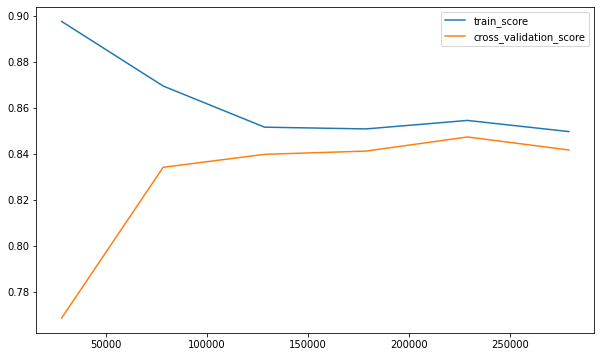

In [ ]:
final_model_AdaBoost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(class_weight="balanced", criterion="gini",max_depth=2),n_estimators = 10 , random_state=0 ) 
evaluation(final_model_AdaBoost, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [ ]:
########################################         ENCODAGE DUMMIES             ###############################

In [ ]:
####################      AVEC LES VARIABLES DONS ET ENCODAGE DUMMIES        ###########################

In [39]:
# test predict individus sans classe
data = data_orig.copy()

# encodage Onehot sur toutes les données (on évite ainsi les erreurs futures)
nb_var = data.shape[1] - 1
data_1_22 = pd.get_dummies(data.iloc[:,1:(data.shape[1]-1)], columns=data.columns[1:(data.shape[1]-1)] )
data_var_qualitatives_temp =  pd.concat([data["IDENT"], data_1_22, data["Top_mon"]], axis=1)
data = data_var_qualitatives_temp
#encodage = OneHotEncoder()
#encodage.fit(data_processing(data.iloc[:,1:nb_var]))

# élimination des individus n'ayant pas de valeur pour la varialbe IFI+
"""IMPORTANT"""
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]

#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int)

# base de données avec des variables corrélées et avec encodage OneHot
data =data_sans_nan

nb_var = data.shape[1] - 1
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [40]:
model_AdaBoost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight = "balanced"), random_state =0 )
param = {'base_estimator__criterion': ['gini','entropy'], 'base_estimator__max_depth' : list(range(2,20, 2)), 'n_estimators' : [20] }

grid_AdaBoost = GridSearchCV(model_AdaBoost, param, cv = 4, scoring = "recall")
resultat_grid_AdaBoost = grid_AdaBoost.fit(train_X_s, train_Y_s)
resultat_grid_AdaBoost.best_params_
#model_AdaBoost.get_params


{'base_estimator__criterion': 'entropy',
 'base_estimator__max_depth': 4,
 'n_estimators': 20}

test set : 
[[ 2496  2183]
 [ 7321 13423]]
              precision    recall  f1-score   support

           1       0.25      0.53      0.34      4679
           2       0.86      0.65      0.74     20744

    accuracy                           0.63     25423
   macro avg       0.56      0.59      0.54     25423
weighted avg       0.75      0.63      0.67     25423

train set : 
[[10711  8066]
 [28507 54408]]
              precision    recall  f1-score   support

           1       0.27      0.57      0.37     18777
           2       0.87      0.66      0.75     82915

    accuracy                           0.64    101692
   macro avg       0.57      0.61      0.56    101692
weighted avg       0.76      0.64      0.68    101692



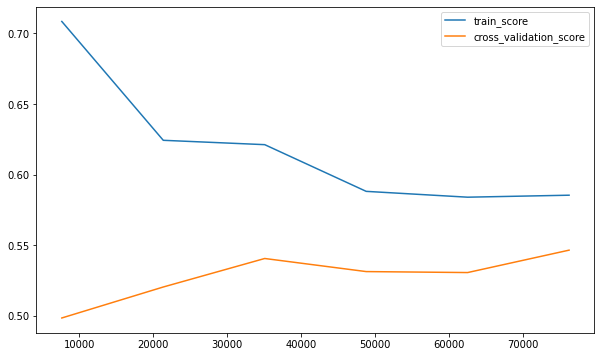

In [41]:
final_model_AdaBoost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(class_weight="balanced", criterion="entropy",max_depth=4),n_estimators = 20 , random_state=0 ) 
evaluation(final_model_AdaBoost, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [43]:
#data_var_qualitatives_temp
quarantiles(model=final_model_AdaBoost, data_orig=data, affichage=True, save=False, path = "/content/drive/MyDrive/spad_score_method_1/avec_dons_encodage_dummies_AdaBoost.xlsx")

                   IDENT     PROBA
20447    204480010263553  0.025010
95018    950190010408013  0.025134
10644    106450010255229  0.025195
29795    297960010339740  0.025383
83489    834900010398134  0.025545
...                  ...       ...
95743    957440010408713  0.859285
111837  1118380010521353  0.859500
107583  1075840010504930  0.859877
94514    945150010407536  0.860194
107668  1076690010505190  0.860451

[127115 rows x 2 columns]
0.500391    528
0.493059    429
0.497693    333
0.499617    291
0.498701    254
           ... 
0.498293      1
0.523241      1
0.493207      1
0.504709      1
0.488884      1
Name: PROBA, Length: 48995, dtype: int64
                    PROBA
20447   (0.02491, 0.4877]
95018   (0.02491, 0.4877]
10644   (0.02491, 0.4877]
29795   (0.02491, 0.4877]
83489   (0.02491, 0.4877]
...                   ...
95743    (0.5127, 0.8605]
111837   (0.5127, 0.8605]
107583   (0.5127, 0.8605]
94514    (0.5127, 0.8605]
107668   (0.5127, 0.8605]

[127115 rows x 1 column

In [ ]:
####################   SANS LES VARIABLES DONS ET ENCODAGE DUMMIES        ###########################

In [44]:
# test predict individus sans classe
data = data_orig.copy()

# on élimine les variables dons
data=data.drop(["GeoFaz_cl", "ImmoFaz_Scl", "ImmoFaz_cl", "Prenom_Phase_cl_H", "Prenom_Phase_cl_F","Onoma-Phase_Scl",
                "Onoma-Phase_CL"],axis=1)

# encodage Onehot sur toutes les données (on évite ainsi les erreurs futures)
nb_var = data.shape[1] - 1
data_1_22 = pd.get_dummies(data.iloc[:,1:(data.shape[1]-1)], columns=data.columns[1:(data.shape[1]-1)] )
data_var_qualitatives_temp =  pd.concat([data["IDENT"], data_1_22, data["Top_mon"]], axis=1)
data = data_var_qualitatives_temp
#encodage = OneHotEncoder()
#encodage.fit(data_processing(data.iloc[:,1:nb_var]))

# élimination des individus n'ayant pas de valeur pour la varialbe IFI+
"""IMPORTANT"""
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]

#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int)

# base de données avec des variables corrélées et avec encodage OneHot
data =data_sans_nan

nb_var = data.shape[1] - 1
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [45]:
model_AdaBoost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight = "balanced"), random_state =0 )
param = {'base_estimator__criterion': ['gini','entropy'], 'base_estimator__max_depth' : list(range(2,20, 2)), 'n_estimators' : [20] }

grid_AdaBoost = GridSearchCV(model_AdaBoost, param, cv = 4, scoring = "recall")
resultat_grid_AdaBoost = grid_AdaBoost.fit(train_X_s, train_Y_s)
resultat_grid_AdaBoost.best_params_
#model_AdaBoost.get_params


{'base_estimator__criterion': 'entropy',
 'base_estimator__max_depth': 6,
 'n_estimators': 20}

test set : 
[[ 2497  2182]
 [ 7629 13115]]
              precision    recall  f1-score   support

           1       0.25      0.53      0.34      4679
           2       0.86      0.63      0.73     20744

    accuracy                           0.61     25423
   macro avg       0.55      0.58      0.53     25423
weighted avg       0.74      0.61      0.66     25423

train set : 
[[11352  7425]
 [28873 54042]]
              precision    recall  f1-score   support

           1       0.28      0.60      0.38     18777
           2       0.88      0.65      0.75     82915

    accuracy                           0.64    101692
   macro avg       0.58      0.63      0.57    101692
weighted avg       0.77      0.64      0.68    101692



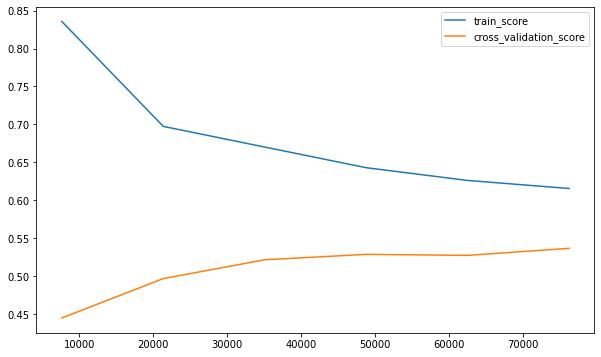

In [46]:
final_model_AdaBoost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(class_weight="balanced", criterion="entropy",max_depth=6),n_estimators = 20 , random_state=0 ) 
evaluation(final_model_AdaBoost, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [48]:
quarantiles(model=final_model_AdaBoost, data_orig=data, affichage=True, save=False, path = "/content/drive/MyDrive/spad_score_method_1/sans_dons_encodage_dummies_AdaBoost.xlsx")

                   IDENT     PROBA
32284    322850010342417  0.000644
30077    300780010340001  0.003931
96698    966990010409586  0.004254
115802  1158030010526662  0.004276
114587  1145880010525561  0.004331
...                  ...       ...
42552    425530010355650  0.973251
90736    907370010404147  0.973752
90735    907360010404147  0.973752
102909  1029100010415966  0.973942
114086  1140870010525118  0.990096

[127115 rows x 2 columns]
0.492493    141
0.500801    135
0.501026    116
0.497037     92
0.500098     78
           ... 
0.500527      1
0.504458      1
0.495913      1
0.499360      1
0.498569      1
Name: PROBA, Length: 72501, dtype: int64
                     PROBA
32284   (-0.000356, 0.477]
30077   (-0.000356, 0.477]
96698   (-0.000356, 0.477]
115802  (-0.000356, 0.477]
114587  (-0.000356, 0.477]
...                    ...
42552        (0.513, 0.99]
90736        (0.513, 0.99]
90735        (0.513, 0.99]
102909       (0.513, 0.99]
114086       (0.513, 0.99]

[127115 row

In [ ]:
#############################################################
#                   MODELE 2 : RANDOM FOREST
#############################################################

In [ ]:
#############################################################
#                   MODELE 2 : BOOSTING
#############################################################

In [ ]:

model_GradientBoostingClassifier = GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1,
                                                              subsample=1,max_features='sqrt', random_state=10)
param = { 'n_estimators':[100,250,500],
         'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001] }

grid_GradientBoostingClassifier = GridSearchCV(model_GradientBoostingClassifier, param_grid= param, cv = 4, scoring = "recall")
resultat_grid_GradientBoostingClassifier = grid_GradientBoostingClassifier.fit(train_X_s, train_Y_s)
resultat_grid_GradientBoostingClassifier.best_params_


{'learning_rate': 0.15, 'n_estimators': 500}

test set : 
[[    2   496]
 [   11 92582]]
              precision    recall  f1-score   support

           1       0.15      0.00      0.01       498
           2       0.99      1.00      1.00     92593

    accuracy                           0.99     93091
   macro avg       0.57      0.50      0.50     93091
weighted avg       0.99      0.99      0.99     93091

train set : 
[[    96   2026]
 [    16 370224]]
              precision    recall  f1-score   support

           1       0.86      0.05      0.09      2122
           2       0.99      1.00      1.00    370240

    accuracy                           0.99    372362
   macro avg       0.93      0.52      0.54    372362
weighted avg       0.99      0.99      0.99    372362



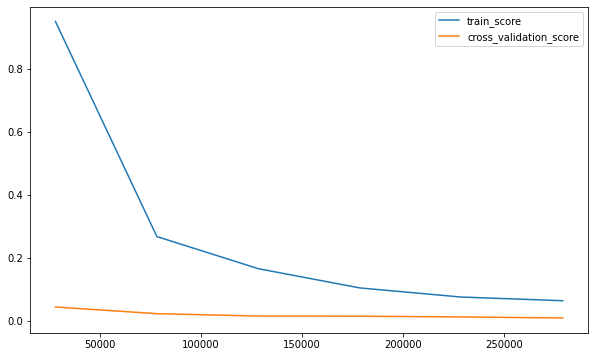

In [ ]:
final_model_GradientBoostingClassifier = GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1,
                                                              subsample=1,max_features='sqrt', random_state=10,
                                                              learning_rate= 0.15, n_estimators= 500)
evaluation(final_model_GradientBoostingClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [ ]:
#######################################################################################################################
#                                                ARBRES DE DECISION
#######################################################################################################################

In [ ]:
# base de données avec des variables corrélées et sans encodage OneHot

train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )
# numéro correspondant à la dernière colonne
nb_var = data.shape[1] - 1

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])

In [ ]:

model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, class_weight = "balanced" )
param = { 'max_depth' :list(range(2,30)), 'criterion': ["gini", "entropy"], 'max_features' : list(range(5,19)),
         'min_samples_split' : np.linspace(0.1, 1.0, 5) }

grid_DecisionTreeClassifier = GridSearchCV(model_DecisionTreeClassifier, param_grid= param, cv = 4, scoring = "recall")
resultat_grid_DecisionTreeClassifier = grid_DecisionTreeClassifier.fit(train_X_s, train_Y_s)
resultat_grid_DecisionTreeClassifier.best_params_


{'criterion': 'entropy',
 'max_depth': 2,
 'max_features': 5,
 'min_samples_split': 0.1}

test set : 
[[  471    27]
 [45168 47425]]
              precision    recall  f1-score   support

           1       0.01      0.95      0.02       498
           2       1.00      0.51      0.68     92593

    accuracy                           0.51     93091
   macro avg       0.50      0.73      0.35     93091
weighted avg       0.99      0.51      0.67     93091

train set : 
[[  2015    107]
 [180302 189938]]
              precision    recall  f1-score   support

           1       0.01      0.95      0.02      2122
           2       1.00      0.51      0.68    370240

    accuracy                           0.52    372362
   macro avg       0.51      0.73      0.35    372362
weighted avg       0.99      0.52      0.67    372362



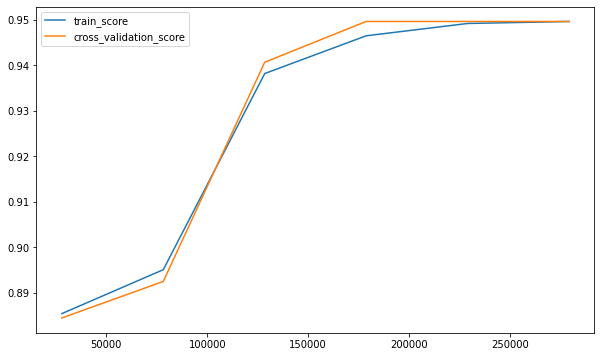

In [ ]:
final_model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, criterion="entropy", class_weight = "balanced", max_depth = 2, max_features=5, min_samples_split=0.1 )
evaluation(final_model_DecisionTreeClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [ ]:

# importance des variables
impVarFirst={"Variable":data.columns[1:-1],"Importance":final_model_DecisionTreeClassifier.feature_importances_}
pd.DataFrame(impVarFirst).sort_values(by="Importance",ascending=False)

,Variable,Importance
20,Don_moyen,0.732512
1,GeoFaz_Scl,0.218157
8,Prenom_Phase_scl_F,0.049330
0,TypeHabi,0.000000
12,Age_F,0.000000
19,Don_max,0.000000
18,Cumul_dons,0.000000
17,Annee_1er_don,0.000000
16,Flag_PA,0.000000
15,codif_RdB,0.000000


[Text(418.5, 453.0, 'GeoFaz_Scl <= 67.5\nentropy = 1.0\nsamples = 372362\nvalue = [186181.0, 186181.0]'),
 Text(209.25, 271.8, 'Don_moyen <= 4.5\nentropy = 0.952\nsamples = 237293\nvalue = [70190.763, 118924.22]'),
 Text(104.625, 90.59999999999997, 'entropy = 0.435\nsamples = 190045\nvalue = [9388.015, 95513.307]'),
 Text(313.875, 90.59999999999997, 'entropy = 0.853\nsamples = 47248\nvalue = [60802.749, 23410.913]'),
 Text(627.75, 271.8, 'Prenom_Phase_scl_F <= 78.5\nentropy = 0.948\nsamples = 135069\nvalue = [115990.237, 67256.78]'),
 Text(523.125, 90.59999999999997, 'entropy = 0.996\nsamples = 76439\nvalue = [44483.396, 38183.599]'),
 Text(732.375, 90.59999999999997, 'entropy = 0.867\nsamples = 58630\nvalue = [71506.84, 29073.181]')]

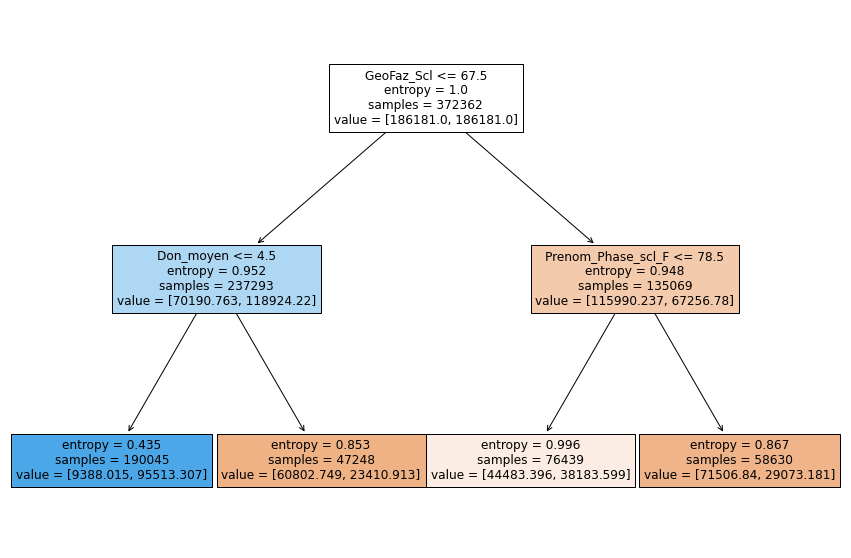

In [ ]:
# affichage graphique de l'arbre (il faut vérifier les noms des colonnes pour qu'on affiche correctement l'arbre)

plt.figure(figsize = (15, 10))
plot_tree(final_model_DecisionTreeClassifier,feature_names = list(data.columns[1:-1]),filled=True)



In [ ]:
##################################################################
# ELIMINATION DES VARIABLES QUI CONTRIBUENT LE PLUS AU MODELE
##################################################################

In [ ]:
# PARTIE 1 : on élimine la variable qui contribue le plus au modèle précédent
data=data.drop(["Don_moyen"],axis=1)


In [ ]:
# base de données avec des variables corrélées et sans encodage OneHot

train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )
nb_var = data.shape[1] - 1

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])

In [ ]:

model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, class_weight = "balanced" )
param = { 'max_depth' :list(range(2,30)), 'criterion': ["gini", "entropy"], 'max_features' : list(range(5,15)),
         'min_samples_split' : np.linspace(0.1, 1.0, 5) }

grid_DecisionTreeClassifier = GridSearchCV(model_DecisionTreeClassifier, param_grid= param, cv = 4, scoring = "recall")
resultat_grid_DecisionTreeClassifier = grid_DecisionTreeClassifier.fit(train_X_s, train_Y_s)
resultat_grid_DecisionTreeClassifier.best_params_


{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 9,
 'min_samples_split': 0.1}

test set : 
[[  417    81]
 [12540 80053]]
              precision    recall  f1-score   support

           1       0.03      0.84      0.06       498
           2       1.00      0.86      0.93     92593

    accuracy                           0.86     93091
   macro avg       0.52      0.85      0.49     93091
weighted avg       0.99      0.86      0.92     93091

train set : 
[[  1828    294]
 [ 50227 320013]]
              precision    recall  f1-score   support

           1       0.04      0.86      0.07      2122
           2       1.00      0.86      0.93    370240

    accuracy                           0.86    372362
   macro avg       0.52      0.86      0.50    372362
weighted avg       0.99      0.86      0.92    372362



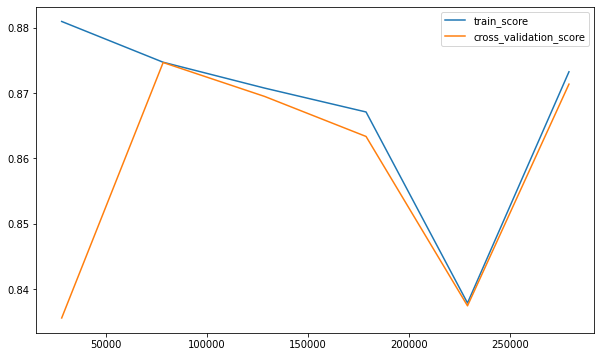

In [ ]:
final_model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, criterion="gini", class_weight = "balanced", max_depth = 8, max_features=9, min_samples_split=0.1 )
evaluation(final_model_DecisionTreeClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [ ]:

#importance des variables
impVarFirst={"Variable":data.columns[1:-1],"Importance":final_model_DecisionTreeClassifier.feature_importances_}
pd.DataFrame(impVarFirst).sort_values(by="Importance",ascending=False)

,Variable,Importance
18,Cumul_dons,0.669001
19,Don_max,0.298596
5,Revenus_iris,0.013495
20,Vingtiles_ISF,0.010643
1,GeoFaz_Scl,0.002385
4,Doublon_ligne,0.002374
2,GeoFaz_cl,0.001567
6,Sexe,0.000941
7,Prenom_Phase_scl_H,0.000686
12,Age_F,0.000313


[Text(642.9130434782609, 513.4, 'Cumul_dons <= 5.5\ngini = 0.5\nsamples = 372362\nvalue = [186181.0, 186181.0]'),
 Text(545.8695652173913, 453.0, 'Don_max <= 6.5\ngini = 0.36\nsamples = 329300\nvalue = [50976.042, 165301.513]'),
 Text(497.3478260869565, 392.6, 'Don_max <= 5.5\ngini = 0.249\nsamples = 308676\nvalue = [26409.275, 155071.213]'),
 Text(363.9130434782609, 332.2, 'Vingtiles_ISF <= 19.5\ngini = 0.173\nsamples = 251748\nvalue = [13336.245, 126519.001]'),
 Text(315.39130434782606, 271.8, 'Doublon_ligne <= 2.5\ngini = 0.152\nsamples = 245526\nvalue = [11142.784, 123402.742]'),
 Text(194.08695652173913, 211.39999999999998, 'GeoFaz_Scl <= 71.5\ngini = 0.214\nsamples = 90712\nvalue = [6317.169, 45579.748]'),
 Text(145.56521739130434, 151.0, 'Revenus_iris <= 7.5\ngini = 0.17\nsamples = 69176\nvalue = [3597.277, 34765.621]'),
 Text(97.04347826086956, 90.59999999999997, 'Sexe <= 2.5\ngini = 0.167\nsamples = 69147\nvalue = [3509.538, 34751.541]'),
 Text(48.52173913043478, 30.1999999999

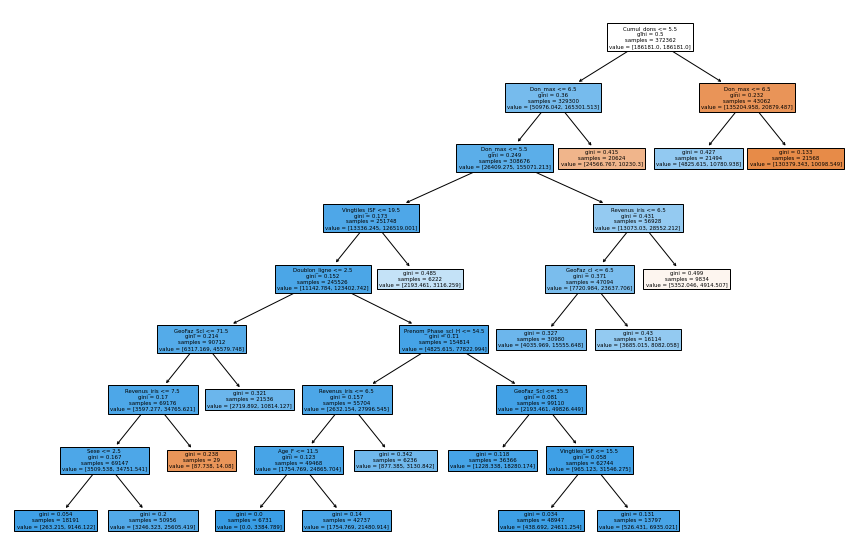

In [ ]:
# affichage graphique de l'arbre (il faut vérifier les noms des colonnes pour qu'on affiche correctement l'arbre)

plt.figure(figsize = (15, 10))
plot_tree(final_model_DecisionTreeClassifier,feature_names = list(data.columns[1:-1]),filled=True)



In [ ]:
##################################################################
##################################################################

In [ ]:
# PARTIE 2 (LA SUITE) : on élimine la variable qui contribue le plus au modèle précédent
data=data.drop(["Annee_1er_don", "Cumul_dons","Don_max"],axis=1)


In [ ]:
# base de données avec des variables corrélées et sans encodage OneHot

train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )
nb_var = data.shape[1] - 1

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])

In [ ]:

model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, class_weight = "balanced" )
param = { 'max_depth' :list(range(2,30)), 'criterion': ["gini", "entropy"], 'max_features' : list(range(5,15)),
         'min_samples_split' : np.linspace(0.1, 1.0, 5) }

grid_DecisionTreeClassifier = GridSearchCV(model_DecisionTreeClassifier, param_grid= param, cv = 4, scoring = "recall")
resultat_grid_DecisionTreeClassifier = grid_DecisionTreeClassifier.fit(train_X_s, train_Y_s)
resultat_grid_DecisionTreeClassifier.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'max_features': 7,
 'min_samples_split': 0.1}

test set : 
[[  385   113]
 [43574 49019]]
              precision    recall  f1-score   support

           1       0.01      0.77      0.02       498
           2       1.00      0.53      0.69     92593

    accuracy                           0.53     93091
   macro avg       0.50      0.65      0.35     93091
weighted avg       0.99      0.53      0.69     93091

train set : 
[[  1609    513]
 [174487 195753]]
              precision    recall  f1-score   support

           1       0.01      0.76      0.02      2122
           2       1.00      0.53      0.69    370240

    accuracy                           0.53    372362
   macro avg       0.50      0.64      0.35    372362
weighted avg       0.99      0.53      0.69    372362



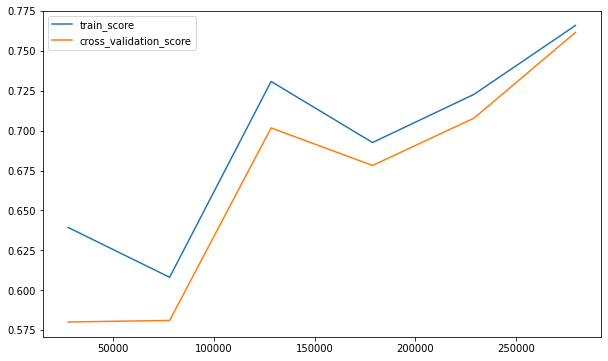

In [ ]:
final_model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, criterion="gini", class_weight = "balanced", max_depth = 2, max_features=7, min_samples_split=0.1 )
evaluation(final_model_DecisionTreeClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [ ]:

#importance des variables
impVarFirst={"Variable":data.columns[1:-1],"Importance":final_model_DecisionTreeClassifier.feature_importances_}
pd.DataFrame(impVarFirst).sort_values(by="Importance",ascending=False)

,Variable,Importance
1,GeoFaz_Scl,0.651813
17,Vingtiles_ISF,0.199837
7,Prenom_Phase_scl_H,0.148350
10,Prenom_Phase_cl_F,0.000000
16,Flag_PA,0.000000
15,codif_RdB,0.000000
14,Prenom_effectif,0.000000
13,Pays_sud,0.000000
12,Age_F,0.000000
11,Age_H,0.000000


[Text(418.5, 453.0, 'GeoFaz_Scl <= 67.5\ngini = 0.5\nsamples = 372362\nvalue = [186181.0, 186181.0]'),
 Text(209.25, 271.8, 'Vingtiles_ISF <= 15.5\ngini = 0.467\nsamples = 237293\nvalue = [70190.763, 118924.22]'),
 Text(104.625, 90.59999999999997, 'gini = 0.431\nsamples = 196266\nvalue = [45009.827, 98437.471]'),
 Text(313.875, 90.59999999999997, 'gini = 0.495\nsamples = 41027\nvalue = [25180.936, 20486.749]'),
 Text(627.75, 271.8, 'Prenom_Phase_scl_H <= 55.5\ngini = 0.465\nsamples = 135069\nvalue = [115990.237, 67256.78]'),
 Text(523.125, 90.59999999999997, 'gini = 0.406\nsamples = 55652\nvalue = [69752.071, 27585.704]'),
 Text(732.375, 90.59999999999997, 'gini = 0.497\nsamples = 79417\nvalue = [46238.165, 39671.076]')]

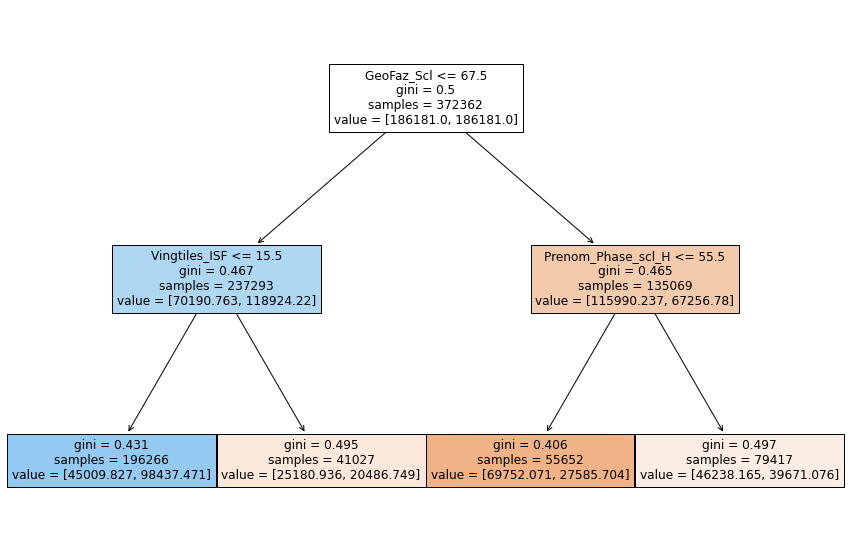

In [ ]:
# affichage graphique de l'arbre (il faut vérifier les noms des colonnes pour qu'on affiche correctement l'arbre)

plt.figure(figsize = (15, 10))
plot_tree(final_model_DecisionTreeClassifier,feature_names = list(data.columns[1:-1]),filled=True)



In [ ]:
##################################################################
##################################################################
##################################################################

In [ ]:
# PARTIE 3 : éliminer les variables corrélées
# tableau de corrélation 
tableau_corr =data_sans_nan.iloc[:,1:23].corr()
variables_corr(tableau_corr, 0.95)


variable :  GeoFaz_Scl
corr pos ['GeoFaz_cl']
corr pos [1.0]

variable :  Prenom_Phase_scl_H
corr pos ['Prenom_Phase_cl_H']
corr pos [0.99]

variable :  Prenom_Phase_scl_F
corr pos ['Prenom_Phase_cl_F']
corr pos [0.99]



In [ ]:
 # éliminer les variables corrélées
data =  data.drop(["GeoFaz_cl", "Prenom_Phase_cl_H", "Prenom_Phase_cl_F"], axis = 1)


In [ ]:
# base de données avec des variables corrélées et sans encodage OneHot

train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )
nb_var = data.shape[1] - 1

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])

In [ ]:

model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, class_weight = "balanced" )
param = { 'max_depth' :list(range(2,30)), 'criterion': ["gini", "entropy"], 'max_features' : list(range(4,10)),
         'min_samples_split' : np.linspace(0.1, 1.0, 5) }

grid_DecisionTreeClassifier = GridSearchCV(model_DecisionTreeClassifier, param_grid= param, cv = 4, scoring = "recall")
resultat_grid_DecisionTreeClassifier = grid_DecisionTreeClassifier.fit(train_X_s, train_Y_s)
resultat_grid_DecisionTreeClassifier.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 8,
 'min_samples_split': 0.325}

test set : 
[[  367   131]
 [39021 53572]]
              precision    recall  f1-score   support

           1       0.01      0.74      0.02       498
           2       1.00      0.58      0.73     92593

    accuracy                           0.58     93091
   macro avg       0.50      0.66      0.38     93091
weighted avg       0.99      0.58      0.73     93091

train set : 
[[  1518    604]
 [155796 214444]]
              precision    recall  f1-score   support

           1       0.01      0.72      0.02      2122
           2       1.00      0.58      0.73    370240

    accuracy                           0.58    372362
   macro avg       0.50      0.65      0.38    372362
weighted avg       0.99      0.58      0.73    372362



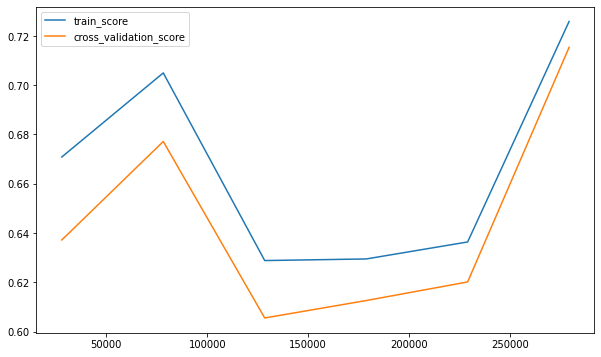

In [ ]:
final_model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, criterion="entropy", class_weight = "balanced", max_depth = 3, max_features=8, min_samples_split=0.325 )
evaluation(final_model_DecisionTreeClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [ ]:

#importance des variables
impVarFirst={"Variable":data.columns[1:-1],"Importance":final_model_DecisionTreeClassifier.feature_importances_}
pd.DataFrame(impVarFirst).sort_values(by="Importance",ascending=False)

,Variable,Importance
4,Revenus_iris,0.765341
1,GeoFaz_Scl,0.151920
6,Prenom_Phase_scl_H,0.082739
0,TypeHabi,0.000000
2,Anciennete,0.000000
3,Doublon_ligne,0.000000
5,Sexe,0.000000
7,Prenom_Phase_scl_F,0.000000
8,Age_H,0.000000
9,Age_F,0.000000


[Text(558.0, 475.65000000000003, 'Revenus_iris <= 6.5\nentropy = 1.0\nsamples = 372362\nvalue = [186181.0, 186181.0]'),
 Text(418.5, 339.75, 'GeoFaz_Scl <= 67.5\nentropy = 0.97\nsamples = 318574\nvalue = [105373.884, 159595.999]'),
 Text(279.0, 203.85000000000002, 'Prenom_Phase_scl_H <= 65.5\nentropy = 0.914\nsamples = 215048\nvalue = [52994.026, 107836.534]'),
 Text(139.5, 67.94999999999999, 'entropy = 0.962\nsamples = 127219\nvalue = [40008.735, 63744.766]'),
 Text(418.5, 67.94999999999999, 'entropy = 0.774\nsamples = 87829\nvalue = [12985.291, 44091.768]'),
 Text(558.0, 203.85000000000002, 'entropy = 1.0\nsamples = 103526\nvalue = [52379.857, 51759.465]'),
 Text(697.5, 339.75, 'entropy = 0.807\nsamples = 53788\nvalue = [80807.116, 26585.001]')]

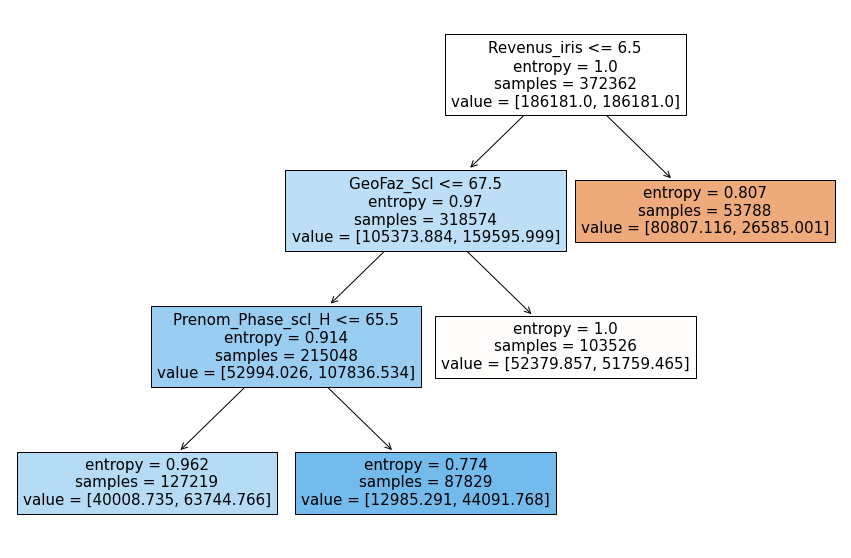

In [ ]:
# affichage graphique de l'arbre (il faut vérifier les noms des colonnes pour qu'on affiche correctement l'arbre)

plt.figure(figsize = (15, 10))
plot_tree(final_model_DecisionTreeClassifier,feature_names = list(data.columns[1:-1]),filled=True)



In [ ]:
#################################################################################################################
#                                                 QUARANTILES               
#################################################################################################################

In [ ]:
####################################################################################
####################################################################################
#                    AVEC VARIABLES DONS
####################################################################################
####################################################################################

In [ ]:
# test predict individus sans classe
data = data_orig.copy()
# élimination des individus n'ayant pas de valeur pour la varialbe IFI+
"""IMPORTANT"""
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]

#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int)

# base de données avec des variables corrélées et sans encodage OneHot
data =data_sans_nan

nb_var = data.shape[1] - 1
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


test set : 
[[  471    27]
 [45168 47425]]
              precision    recall  f1-score   support

           1       0.01      0.95      0.02       498
           2       1.00      0.51      0.68     92593

    accuracy                           0.51     93091
   macro avg       0.50      0.73      0.35     93091
weighted avg       0.99      0.51      0.67     93091

train set : 
[[  2015    107]
 [180302 189938]]
              precision    recall  f1-score   support

           1       0.01      0.95      0.02      2122
           2       1.00      0.51      0.68    370240

    accuracy                           0.52    372362
   macro avg       0.51      0.73      0.35    372362
weighted avg       0.99      0.52      0.67    372362



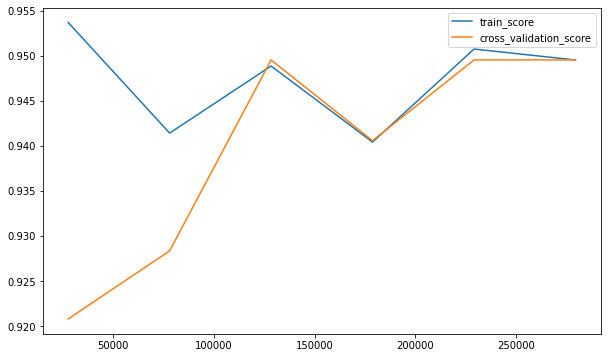

In [ ]:
final_model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, criterion="entropy", class_weight = "balanced", max_depth = 2, max_features=5, min_samples_split=0.1 )
evaluation(final_model_DecisionTreeClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [ ]:
quarantiles(model=final_model_DecisionTreeClassifier, data_orig=data_orig, affichage=True, save=False, path = "/content/drive/MyDrive/spad_score_method_1/avec_tranche_DecisionTreeClassifier.xlsx")

                 IDENT     PROBA
306292  30629304028272  0.089494
171184  17118503570269  0.089494
407080  40708104147583  0.089494
407079  40708004147582  0.089494
407077  40707804147580  0.089494
...                ...       ...
412578  41257904153257  0.722006
412576  41257704153255  0.722006
159678  15967903476110  0.722006
159622  15962303475531  0.722006
484521  48452204239268  0.722006

[484522 rows x 2 columns]
0.089494    237497
0.538103     99730
0.710945     75806
0.722006     71489
Name: PROBA, dtype: int64


ValueError: ignored

(484522, 24)

In [ ]:
####################################################################################
####################################################################################
#                    SANS VARIABLES DONS
####################################################################################
####################################################################################

In [ ]:

# test predict individus sans classe
data = data_orig.copy()

# il nous faut toutes les variables (*,24)
print("dim data_orig: ",data.shape)

# on élimine les variables dons
data=data.drop(["Annee_1er_don", "Cumul_dons","Don_max", "Don_moyen"],axis=1)

# élimination des individus n'ayant pas de valeur pour la varialbe IFI+
"""IMPORTANT"""
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]

#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int)

# base de données avec des variables corrélées et sans encodage OneHot
data =data_sans_nan

nb_var = data.shape[1] - 1
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])

dim data_orig:  (484522, 24)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


test set : 
[[  385   113]
 [43574 49019]]
              precision    recall  f1-score   support

           1       0.01      0.77      0.02       498
           2       1.00      0.53      0.69     92593

    accuracy                           0.53     93091
   macro avg       0.50      0.65      0.35     93091
weighted avg       0.99      0.53      0.69     93091

train set : 
[[  1609    513]
 [174487 195753]]
              precision    recall  f1-score   support

           1       0.01      0.76      0.02      2122
           2       1.00      0.53      0.69    370240

    accuracy                           0.53    372362
   macro avg       0.50      0.64      0.35    372362
weighted avg       0.99      0.53      0.69    372362



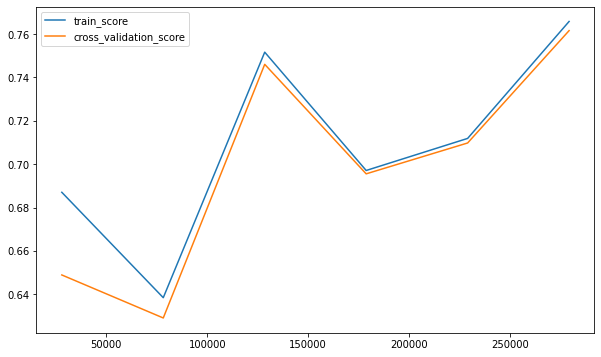

In [ ]:
final_model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, criterion="gini", class_weight = "balanced", max_depth = 2, max_features=7, min_samples_split=0.1 )
evaluation(final_model_DecisionTreeClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [ ]:
quarantiles(model=final_model_DecisionTreeClassifier, data_orig=data_orig, affichage=True, save=True, path = "/content/drive/MyDrive/spad_score_method_1/sans_tranche_DecisionTreeClassifier.xlsx")

                 IDENT     PROBA
484521  48452204239268  0.313773
220803  22080403910938  0.313773
220802  22080303910937  0.313773
220801  22080203910931  0.313773
385988  38598904126038  0.313773
...                ...       ...
403417  40341804143891  0.716598
177812  17781303634458  0.716598
403412  40341304143886  0.716598
177744  17774503633679  0.716598
411434  41143504152097  0.716598

[484522 rows x 2 columns]
0.313773    308986
0.538221    103246
0.716598     72290
Name: PROBA, dtype: int64


ValueError: ignored

In [ ]:
###################################################################################################################@
###################################################################################################################@
#                                   DECISION TREE CLASSIFIER  ----  AVEC VARIABLES QUALITATIVES
###################################################################################################################@
###################################################################################################################@

In [ ]:
####################################################################################
####################################################################################
#                    AVEC VARIABLES DONS
####################################################################################
####################################################################################

In [ ]:
# test predict individus sans classe
data = data_orig.copy()

# encodage Onehot sur toutes les données (on évite ainsi les erreurs futures)
nb_var = data.shape[1] - 1
data_1_22 = pd.get_dummies(data.iloc[:,1:(data.shape[1]-1)], columns=data.columns[1:(data.shape[1]-1)] )
data_var_qualitatives_temp =  pd.concat([data["IDENT"], data_1_22, data["IFI+"]], axis=1)
data = data_var_qualitatives_temp
#encodage = OneHotEncoder()
#encodage.fit(data_processing(data.iloc[:,1:nb_var]))

# élimination des individus n'ayant pas de valeur pour la varialbe IFI+
"""IMPORTANT"""
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]

#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int)

# base de données avec des variables corrélées et avec encodage OneHot
data =data_sans_nan

nb_var = data.shape[1] - 1
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:

model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, class_weight = "balanced" )
param = { 'max_depth' :list(range(2,30)), 'criterion': ["gini", "entropy"], 'max_features' : [10,16,20],
         'min_samples_split' : np.linspace(0.1, 1.0, 5) }

grid_DecisionTreeClassifier = GridSearchCV(model_DecisionTreeClassifier, param_grid= param, cv = 4, scoring = "recall")
resultat_grid_DecisionTreeClassifier = grid_DecisionTreeClassifier.fit(train_X_s, train_Y_s)
resultat_grid_DecisionTreeClassifier.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'max_features': 10,
 'min_samples_split': 1.0}

test set : 
[[  490     8]
 [74856 17737]]
              precision    recall  f1-score   support

           1       0.01      0.98      0.01       498
           2       1.00      0.19      0.32     92593

    accuracy                           0.20     93091
   macro avg       0.50      0.59      0.17     93091
weighted avg       0.99      0.20      0.32     93091

train set : 
[[  2092     30]
 [299561  70679]]
              precision    recall  f1-score   support

           1       0.01      0.99      0.01      2122
           2       1.00      0.19      0.32    370240

    accuracy                           0.20    372362
   macro avg       0.50      0.59      0.17    372362
weighted avg       0.99      0.20      0.32    372362



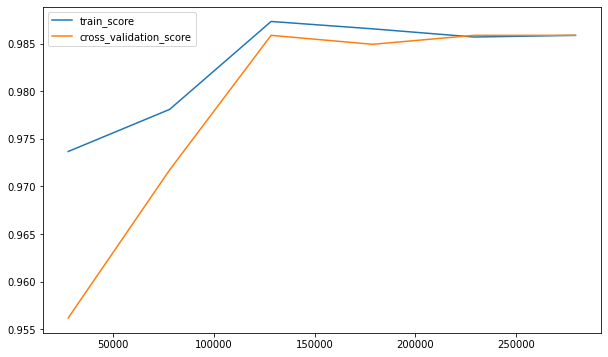

In [ ]:
final_model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, criterion="gini", class_weight = "balanced", max_depth = 2, max_features=7, min_samples_split=0.1 )
evaluation(final_model_DecisionTreeClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [ ]:
#importance des variables
impVarFirst={"Variable":data.columns[1:-1],"Importance":final_model_DecisionTreeClassifier.feature_importances_}
pd.DataFrame(impVarFirst).sort_values(by="Importance",ascending=False)

,Variable,Importance
217,Cumul_dons_2,0.944658
36,GeoFaz_Scl_72,0.054732
192,Pays_sud_1,0.000610
0,TypeHabi_1,0.000000
172,Age_H_5,0.000000
...,...,...
92,Prenom_Phase_scl_H_43,0.000000
93,Prenom_Phase_scl_H_44,0.000000
94,Prenom_Phase_scl_H_45,0.000000
95,Prenom_Phase_scl_H_51,0.000000


In [ ]:
quarantiles(model=final_model_DecisionTreeClassifier, data_orig=data_var_qualitatives_temp, affichage=True, save=False, path = "/content/drive/MyDrive/spad_score_method_1/avec_tranche_DecisionTreeClassifier.xlsx")

                 IDENT     PROBA
256363  25636403968391  0.000000
260455  26045603973070  0.000000
447738  44773904190526  0.000000
320729  32073004045847  0.000000
125427  12542803232815  0.000000
...                ...       ...
377891  37789204117839  0.654584
58651    5865202154473  0.654584
336211  33621204067088  0.654584
107992  10799303067006  0.654584
38049    3805001638438  0.654584

[484522 rows x 2 columns]
0.536232    362534
0.070889     85860
0.654584     33534
0.000000      2594
Name: PROBA, dtype: int64


ValueError: ignored

In [ ]:
####################################################################################
####################################################################################
#                    SANS VARIABLES DONS
####################################################################################
####################################################################################

In [ ]:
# test predict individus sans classe
data = data_orig.copy()

# on élimine les variables dons
data=data.drop(["Annee_1er_don", "Cumul_dons","Don_max", "Don_moyen"],axis=1)

# encodage Onehot sur toutes les données (on évite ainsi les erreurs futures)
nb_var = data.shape[1] - 1
data_1_22 = pd.get_dummies(data.iloc[:,1:(data.shape[1]-1)], columns=data.columns[1:(data.shape[1]-1)] )
data_var_qualitatives_temp =  pd.concat([data["IDENT"], data_1_22, data["IFI+"]], axis=1)
data = data_var_qualitatives_temp

# élimination des individus n'ayant pas de valeur pour la varialbe IFI+
"""IMPORTANT"""
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]

#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int)

# base de données avec des variables corrélées et avec encodage OneHot
data =data_sans_nan

nb_var = data.shape[1] - 1
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, class_weight = "balanced" )
param = { 'max_depth' :list(range(2,30)), 'criterion': ["gini", "entropy"], 'max_features' : [10,16,20],
         'min_samples_split' : np.linspace(0.1, 1.0, 5) }

grid_DecisionTreeClassifier = GridSearchCV(model_DecisionTreeClassifier, param_grid= param, cv = 4, scoring = "recall")
resultat_grid_DecisionTreeClassifier = grid_DecisionTreeClassifier.fit(train_X_s, train_Y_s)
resultat_grid_DecisionTreeClassifier.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'max_features': 20,
 'min_samples_split': 0.55}

test set : 
[[  388   110]
 [52804 39789]]
              precision    recall  f1-score   support

           1       0.01      0.78      0.01       498
           2       1.00      0.43      0.60     92593

    accuracy                           0.43     93091
   macro avg       0.50      0.60      0.31     93091
weighted avg       0.99      0.43      0.60     93091

train set : 
[[  1649    473]
 [212122 158118]]
              precision    recall  f1-score   support

           1       0.01      0.78      0.02      2122
           2       1.00      0.43      0.60    370240

    accuracy                           0.43    372362
   macro avg       0.50      0.60      0.31    372362
weighted avg       0.99      0.43      0.59    372362



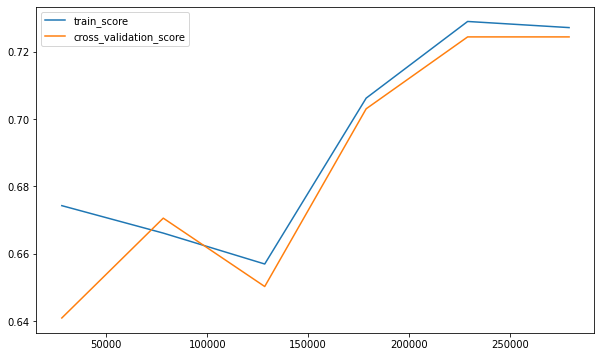

In [ ]:
final_model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, criterion="gini", class_weight = "balanced", max_depth = 2, max_features=20, min_samples_split=0.55 )
evaluation(final_model_DecisionTreeClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [ ]:
#importance des variables
impVarFirst={"Variable":data.columns[1:-1],"Importance":final_model_DecisionTreeClassifier.feature_importances_}
pd.DataFrame(impVarFirst).sort_values(by="Importance",ascending=False)

,Variable,Importance
1,TypeHabi_2,0.728376
74,Sexe_3,0.271624
143,Prenom_Phase_scl_F_65,0.000000
145,Prenom_Phase_scl_F_67,0.000000
146,Prenom_Phase_scl_F_71,0.000000
...,...,...
80,Prenom_Phase_scl_H_14,0.000000
81,Prenom_Phase_scl_H_21,0.000000
82,Prenom_Phase_scl_H_22,0.000000
83,Prenom_Phase_scl_H_23,0.000000


[Text(334.8, 453.0, 'TypeHabi_2 <= 0.5\ngini = 0.5\nsamples = 372362\nvalue = [186181.0, 186181.0]'),
 Text(167.4, 271.8, 'gini = 0.479\nsamples = 141942\nvalue = [106953.176, 70764.771]'),
 Text(502.20000000000005, 271.8, 'Sexe_3 <= 0.5\ngini = 0.483\nsamples = 230420\nvalue = [79227.824, 115416.229]'),
 Text(334.8, 90.59999999999997, 'gini = 0.451\nsamples = 158591\nvalue = [41500.289, 79512.12]'),
 Text(669.6, 90.59999999999997, 'gini = 0.5\nsamples = 71829\nvalue = [37727.535, 35904.109]')]

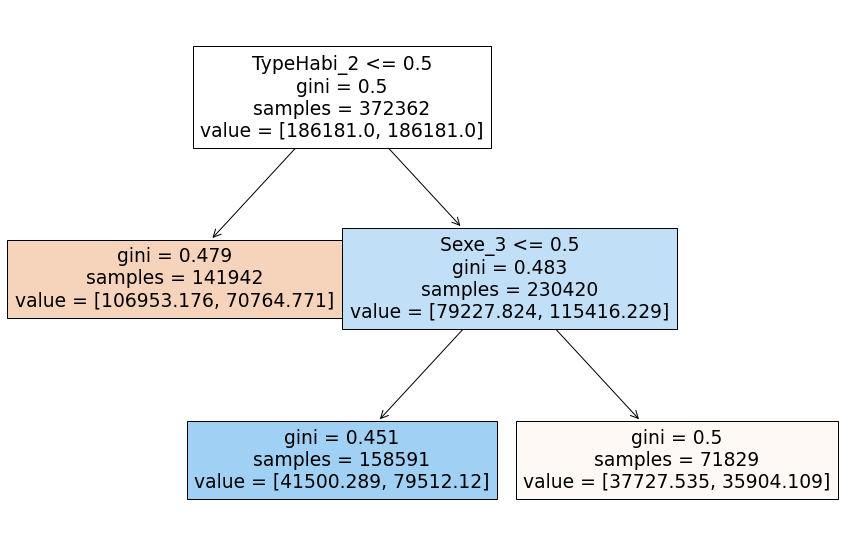

In [ ]:
# affichage graphique de l'arbre (il faut vérifier les noms des colonnes pour qu'on affiche correctement l'arbre)

plt.figure(figsize = (15, 10))
plot_tree(final_model_DecisionTreeClassifier,feature_names = list(data.columns[1:-1]),filled=True)


In [ ]:
quarantiles(model=final_model_DecisionTreeClassifier, data_orig=data_var_qualitatives_temp, affichage=True, save=False, path = "/content/drive/MyDrive/spad_score_method_1/avec_tranche_DecisionTreeClassifier.xlsx")

                 IDENT     PROBA
242260  24226103950284  0.342942
257041  25704203969111  0.342942
257043  25704403969113  0.342942
257046  25704703969116  0.342942
257050  25705103969123  0.342942
...                ...       ...
224571  22457203923861  0.601814
347190  34719104079633  0.601814
347191  34719204079634  0.601814
347218  34721904079662  0.601814
0            101001347  0.601814

[484522 rows x 2 columns]
0.342942    206791
0.601814    184305
0.512382     93426
Name: PROBA, dtype: int64


ValueError: ignored

In [ ]:
####################################################################################################################
####################################################################################################################

In [ ]:
####################################################################################
####################################################################################
#                   TEST AVEC VARIABLES DONS
####################################################################################
####################################################################################

In [12]:
# test predict individus sans classe
data = data_orig.copy()

# encodage Onehot sur toutes les données (on évite ainsi les erreurs futures)
nb_var = data.shape[1] - 1
data_1_22 = pd.get_dummies(data.iloc[:,1:(data.shape[1]-1)], columns=data.columns[1:(data.shape[1]-1)] )
data_var_qualitatives_temp =  pd.concat([data["IDENT"], data_1_22, data["Top_mon"]], axis=1)
data = data_var_qualitatives_temp
#encodage = OneHotEncoder()
#encodage.fit(data_processing(data.iloc[:,1:nb_var]))

# élimination des individus n'ayant pas de valeur pour la varialbe IFI+
"""IMPORTANT"""
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]

#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int)

# base de données avec des variables corrélées et avec encodage OneHot
data =data_sans_nan

nb_var = data.shape[1] - 1
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [13]:

model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, class_weight = "balanced" )
param = { 'max_depth' :list(range(2,30)), 'criterion': ["gini", "entropy"], 'max_features' : list(range(5,19)),
         'min_samples_split' : np.linspace(0.1, 1.0, 5) }

grid_DecisionTreeClassifier = GridSearchCV(model_DecisionTreeClassifier, param_grid= param, cv = 4, scoring = "recall", n_jobs=2)
resultat_grid_DecisionTreeClassifier = grid_DecisionTreeClassifier.fit(train_X_s, train_Y_s)
resultat_grid_DecisionTreeClassifier.best_params_


{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 12,
 'min_samples_split': 0.1}

test set : 
[[ 3351  1328]
 [12595  8149]]
              precision    recall  f1-score   support

           1       0.21      0.72      0.32      4679
           2       0.86      0.39      0.54     20744

    accuracy                           0.45     25423
   macro avg       0.54      0.55      0.43     25423
weighted avg       0.74      0.45      0.50     25423

train set : 
[[13558  5219]
 [49938 32977]]
              precision    recall  f1-score   support

           1       0.21      0.72      0.33     18777
           2       0.86      0.40      0.54     82915

    accuracy                           0.46    101692
   macro avg       0.54      0.56      0.44    101692
weighted avg       0.74      0.46      0.50    101692



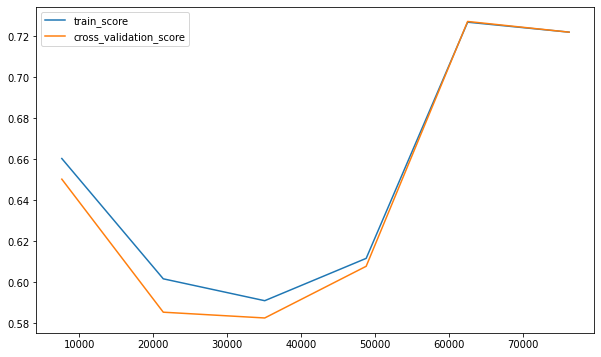

In [14]:
final_model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, criterion="gini", class_weight = "balanced", max_depth = 5, max_features=12, min_samples_split=0.1 )
evaluation(final_model_DecisionTreeClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [18]:
quarantiles(model=final_model_DecisionTreeClassifier, data_orig = data_var_qualitatives_temp, affichage=True, save=False, path = "/content/drive/MyDrive/spad_score_method_1/sans_tranche_DecisionTreeClassifier.xlsx")

                    IDENT     PROBA
326879   1997650110017039  0.356147
1047495  9203810360096844  0.356147
62522     625230010373561  0.356147
849653   7225390290009607  0.356147
849652   7225380290009606  0.356147
...                   ...       ...
451172   3240580130071337  0.788502
690968   5638540260015927  0.788502
1008510  8813960360057859  0.788502
570805   4436910210000238  0.788502
421178   2940640130041343  0.788502

[1219999 rows x 2 columns]
0.505833    564902
0.411379    374878
0.356147     60354
0.666874     48049
0.618663     34168
0.419657     31220
0.493656     28327
0.697532     27145
0.600906     25894
0.788502     25062
Name: PROBA, dtype: int64


ValueError: ignored

[Text(532.6363636363636, 498.3, 'Age_H_12 <= 0.5\ngini = 0.5\nsamples = 101692\nvalue = [50846.0, 50846.0]'),
 Text(380.4545454545455, 407.70000000000005, 'Potentiel_prenom_7 <= 0.5\ngini = 0.498\nsamples = 60187\nvalue = [33068.72, 29419.729]'),
 Text(304.3636363636364, 317.1, 'ImmoFaz_Scl_51 <= 0.5\ngini = 0.498\nsamples = 57586\nvalue = [32077.633, 28049.159]'),
 Text(228.27272727272728, 226.5, 'GeoFaz_Scl_74 <= 0.5\ngini = 0.499\nsamples = 55762\nvalue = [29816.547, 27442.674]'),
 Text(152.1818181818182, 135.89999999999998, 'ImmoFaz_cl_5 <= 0.5\ngini = 0.5\nsamples = 53086\nvalue = [27869.576, 26242.582]'),
 Text(76.0909090909091, 45.299999999999955, 'gini = 0.5\nsamples = 51136\nvalue = [26058.0, 25457.034]'),
 Text(228.27272727272728, 45.299999999999955, 'gini = 0.422\nsamples = 1950\nvalue = [1811.577, 785.548]'),
 Text(304.3636363636364, 135.89999999999998, 'gini = 0.472\nsamples = 2676\nvalue = [1946.971, 1200.092]'),
 Text(380.4545454545455, 226.5, 'gini = 0.334\nsamples = 18

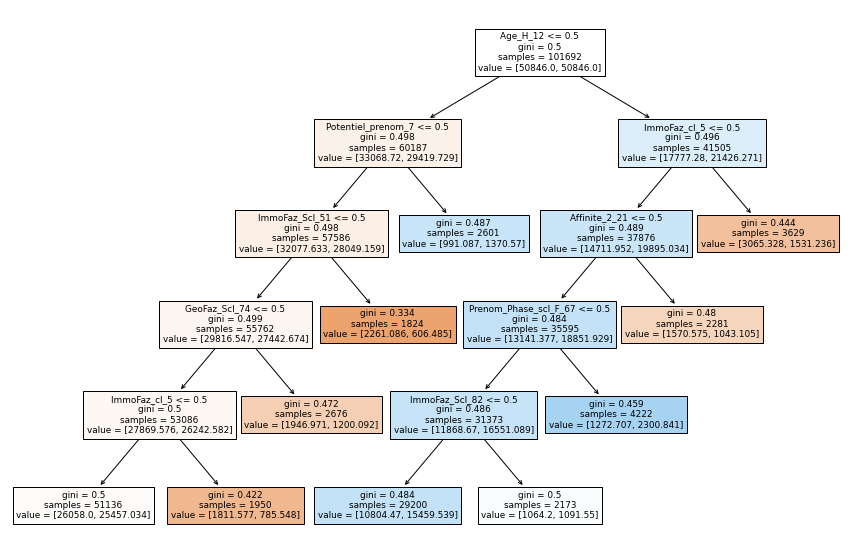

In [16]:
#importance des variables
impVarFirst={"Variable":data.columns[1:-1],"Importance":final_model_DecisionTreeClassifier.feature_importances_}
pd.DataFrame(impVarFirst).sort_values(by="Importance",ascending=False)


# affichage graphique de l'arbre (il faut vérifier les noms des colonnes pour qu'on affiche correctement l'arbre)
plt.figure(figsize = (15, 10))
plot_tree(final_model_DecisionTreeClassifier,feature_names = list(data.columns[1:-1]),filled=True)




In [ ]:
####################################################################################
####################################################################################
#                   TEST AVEC VARIABLES DONS
####################################################################################
####################################################################################

In [19]:
# test predict individus sans classe
data = data_orig.copy()

# on élimine les variables dons
data=data.drop(["GeoFaz_cl", "ImmoFaz_Scl", "ImmoFaz_cl", "Prenom_Phase_cl_H", "Prenom_Phase_cl_F",
                "Onoma-Phase_Scl", "Onoma-Phase_CL"],axis=1)

# encodage Onehot sur toutes les données (on évite ainsi les erreurs futures)
nb_var = data.shape[1] - 1
data_1_22 = pd.get_dummies(data.iloc[:,1:(data.shape[1]-1)], columns=data.columns[1:(data.shape[1]-1)] )
data_var_qualitatives_temp =  pd.concat([data["IDENT"], data_1_22, data["Top_mon"]], axis=1)
data = data_var_qualitatives_temp
#encodage = OneHotEncoder()
#encodage.fit(data_processing(data.iloc[:,1:nb_var]))

# élimination des individus n'ayant pas de valeur pour la varialbe IFI+
"""IMPORTANT"""
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]

#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int)

# base de données avec des variables corrélées et avec encodage OneHot
data =data_sans_nan

nb_var = data.shape[1] - 1
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [20]:

model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, class_weight = "balanced" )
param = { 'max_depth' :list(range(2,30)), 'criterion': ["gini", "entropy"], 'max_features' : list(range(5,19)),
         'min_samples_split' : np.linspace(0.1, 1.0, 5) }

grid_DecisionTreeClassifier = GridSearchCV(model_DecisionTreeClassifier, param_grid= param, cv = 4, scoring = "recall", n_jobs=2)
resultat_grid_DecisionTreeClassifier = grid_DecisionTreeClassifier.fit(train_X_s, train_Y_s)
resultat_grid_DecisionTreeClassifier.best_params_


{'criterion': 'gini',
 'max_depth': 2,
 'max_features': 5,
 'min_samples_split': 1.0}

test set : 
[[  390  4289]
 [  611 20133]]
              precision    recall  f1-score   support

           1       0.39      0.08      0.14      4679
           2       0.82      0.97      0.89     20744

    accuracy                           0.81     25423
   macro avg       0.61      0.53      0.51     25423
weighted avg       0.74      0.81      0.75     25423

train set : 
[[ 1539 17238]
 [ 2379 80536]]
              precision    recall  f1-score   support

           1       0.39      0.08      0.14     18777
           2       0.82      0.97      0.89     82915

    accuracy                           0.81    101692
   macro avg       0.61      0.53      0.51    101692
weighted avg       0.74      0.81      0.75    101692



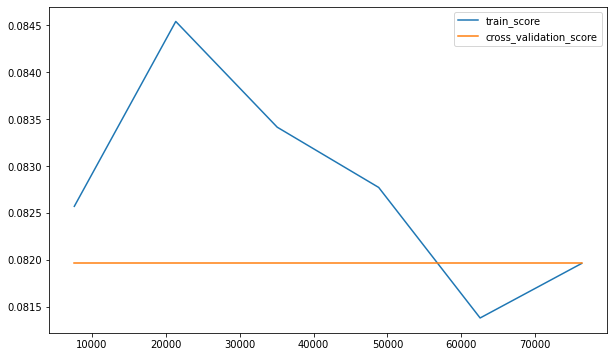

In [27]:
final_model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, criterion="gini", class_weight = "balanced", max_depth = 50, max_features=30, min_samples_split=1.0 )
evaluation(final_model_DecisionTreeClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [24]:
quarantiles(model=final_model_DecisionTreeClassifier, data_orig = data_var_qualitatives_temp, affichage=True, save=False, path = "/content/drive/MyDrive/spad_score_method_1/sans_tranche_DecisionTreeClassifier.xlsx")

                     IDENT     PROBA
473080    3459660160002552  0.395492
252445    1253310050065321  0.395492
979346    8522320360028695  0.395492
979344    8522300360028693  0.395492
1137579  10104650370026928  0.395492
...                    ...       ...
415250    2881360130035415  0.503694
415249    2881350130035414  0.503694
415248    2881340130035413  0.503694
415227    2881130130035392  0.503694
1219998  10928840370109347  0.503694

[1219999 rows x 2 columns]
0.503694    1171011
0.395492      48988
Name: PROBA, dtype: int64


ValueError: ignored